# wavefunction plots
### TODO: 
 * show scale bar on both rydberg and low-lying wavefunction plots
 * make an energy diagram, perhaps like the one in Steck for D1/D2 lines. could do this in PPT, but be nice to do everything here. 
 * make a plot showing the Rb spectral lines, as if they had gone through a diffraction grating?
 * add misc. labels, like "Rubidium Fine structure probability densities, |psi|^2" 

In [7]:
from numpy import *
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import colors
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
from time import time

# path stuff
import sys
sys.path.append('/images')

from arc import *
from scipy.special import sph_harm as ylm

# my special sauce
from physconsts import *
from rbconsts import *
from amophys import j3_from_j1j2
from field_funcs import *

# other
mpl.rcParams.update(mpl.rcParamsDefault)

#### layout stuff
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

# define our atom
atom=Rubidium(87)

In [ ]:
# a note about saving the figure: use the following to get the correct 
# background color
# savefig('figname.png', facecolor=fig.get_facecolor(), transparent=True)

## setup

In [39]:
def get_psi_r(n,l,j,rmax,rmin=0,dr=0.001,vector=False):
    """
    Returns the an interpolating funcion for psi_{n,l,j}, taking argument radial position r 
    """
    rmin = max(amin(rmin),atom.alphaC**(1/3.0)/10)
    rmax = min(amax(rmax),2.0*n*(n+15.0))

    rpts, radialpts = atom.radialWavefunction(l,0.5,j,\
                                     atom.getEnergy(n, l, j)/27.211,\
                                     rmin,\
                                     rmax,\
                                     step=dr)

    # ensure that psi goes to zero at the origin
#     intrp_pts = array([0] + list(rpts))
#     psi_pts = array([0] + list(radialpts))
    intrp_pts = rpts
    psi_pts = radialpts
    if vector:
        psi_radial = lambda x: where(x > rmin, interp(x, intrp_pts, psi_pts), 0)
    else:
        psi_radial = lambda x: interp(x, intrp_pts, psi_pts) if x > rmin else 0

    return psi_radial

def get_states(nmax,lmax,jmax,mjmax,nmin=5):
    """return a list of lists specifying fine structure states [n,l,j,mj]"""
    states = []
    for n in range(nmin,nmax+1):
        lm = lmax if lmax <= n-1 else n-1
        for l in range(0, lm+1):
            jm = jmax if jmax <= l + 1/2 else l + 1/2
            for j in j3_from_j1j2(l,1/2):
                if j > jm:
                    break
                mjm = mjmax if mjmax <= j else j
                for m in [(2*i+1)*1/2 for i in range(0,int(j+1/2))]:
                    if m > mjm:
                        break
                    states.append([n,l,j,m])
    return states

def halfint_to_fracstr(j):
    "converts half-integral float to a fractional str"
    return f'{int(2*j)}/2'

In [40]:
get_states(8,2,5/2,5/2)

[[5, 0, 0.5, 0.5],
 [5, 1, 0.5, 0.5],
 [5, 1, 1.5, 0.5],
 [5, 1, 1.5, 1.5],
 [5, 2, 1.5, 0.5],
 [5, 2, 1.5, 1.5],
 [5, 2, 2.5, 0.5],
 [5, 2, 2.5, 1.5],
 [5, 2, 2.5, 2.5],
 [6, 0, 0.5, 0.5],
 [6, 1, 0.5, 0.5],
 [6, 1, 1.5, 0.5],
 [6, 1, 1.5, 1.5],
 [6, 2, 1.5, 0.5],
 [6, 2, 1.5, 1.5],
 [6, 2, 2.5, 0.5],
 [6, 2, 2.5, 1.5],
 [6, 2, 2.5, 2.5],
 [7, 0, 0.5, 0.5],
 [7, 1, 0.5, 0.5],
 [7, 1, 1.5, 0.5],
 [7, 1, 1.5, 1.5],
 [7, 2, 1.5, 0.5],
 [7, 2, 1.5, 1.5],
 [7, 2, 2.5, 0.5],
 [7, 2, 2.5, 1.5],
 [7, 2, 2.5, 2.5],
 [8, 0, 0.5, 0.5],
 [8, 1, 0.5, 0.5],
 [8, 1, 1.5, 0.5],
 [8, 1, 1.5, 1.5],
 [8, 2, 1.5, 0.5],
 [8, 2, 1.5, 1.5],
 [8, 2, 2.5, 0.5],
 [8, 2, 2.5, 1.5],
 [8, 2, 2.5, 2.5]]

## fine structure wavefunction plots

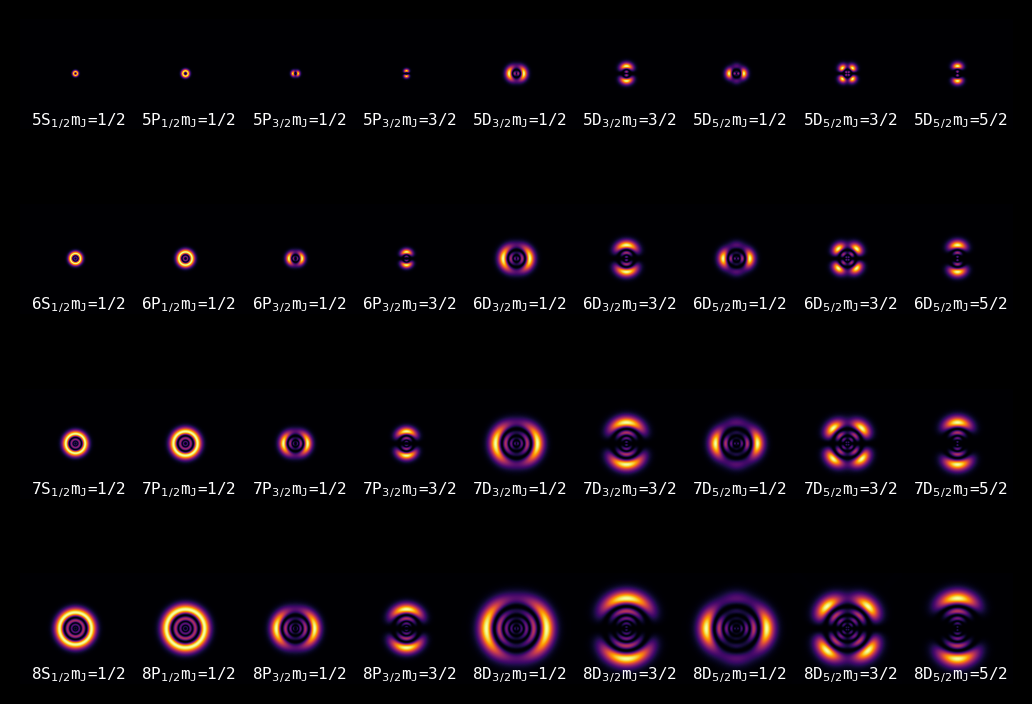

In [55]:
# plot a wavefunction with both radial and angular parts.
# the angular part ends up being really slow. try with one term to diagnose.

nmax = 8
lmax = 2
jmax = 5/2
mjmax = jmax
states = get_states(nmax,lmax,jmax,mjmax)

l_dict = {0:"S",1:"P",2:"D",3:"F"}

rmax = 130 # max radius

plt.set_cmap('inferno') # set the colormap

plt.close()
# rows = cols = int(ceil(sqrt(len(states)))) # enforce square grid
rows = 1 + nmax - 5
cols = int(ceil(len(states)/rows))

plt.figure(facecolor='black',dpi=200)
gs = gridspec.GridSpec(rows,cols)
gs.update(wspace=-0.0,hspace=0)

def configure_ax(ax):
    ax.set_aspect('equal')
    ax.set_axis_off()

# loop over states, plot each
for i,state in enumerate(states):

    # wavefunction params
    n,l,j,mj = state

    ylm_safe = lambda m,l,phi,theta: ylm(m,l,phi,theta) if abs(m) <= l else 0

    psi_r = get_psi_r(n,l,j,rmax=rmax,vector=True)
    psi_ylm = lambda theta,phi: float(clebsch_gordan(l,1/2,j,mj-1/2,1/2,mj))*ylm_safe(mj-1/2,l,phi,theta) + \
                                 float(clebsch_gordan(l,1/2,j,mj+1/2,-1/2,mj))*ylm_safe(mj+1/2,l,phi,theta)

    pts = 400
    xarr,midpt,rho,phi = get_meshgrid(rmax,pts,polar=True)
    theta = full(rho.shape, pi/2) # use approx. to pi to avoid div by zero

    ylm_mesh = psi_ylm(phi,theta)
    r_mesh = psi_r(rho)

    psi_mesh = ylm_mesh*r_mesh
    prob_mesh = abs(psi_mesh)**2
#     print(amax(prob_mesh))
    prob_mesh /= amax(prob_mesh)
#     print(prob_mesh)

#     print("n={},l={},j={},mj={}".format(*state))
        
    ax = plt.subplot(gs[i])
    plt.axis('on')
    
    # settings that apply to each ax
    configure_ax(ax)
    jstr = "".join([r'$_{}$'.format(x) for x in halfint_to_fracstr(j)]) #  the J subscript
    ax.text(0.1*pts,0.95*pts,s=f'{n}{l_dict[l]}'+jstr+r'$\mathregular{m_J}$'+
            '='+halfint_to_fracstr(mj),
            color='white',size='xx-small',family='monospace')
    
    cax = ax.imshow(prob_mesh) #, extent=[-hw,hw,-hw,hw])
    # cax.set_norm(colors.Normalize(vmin=0, vmax=1))
#     cbar = fig.colorbar(cax)
# plt.subplots_adjust(hspace=0.0,wspace=0.0,right=0.7)
plt.show()

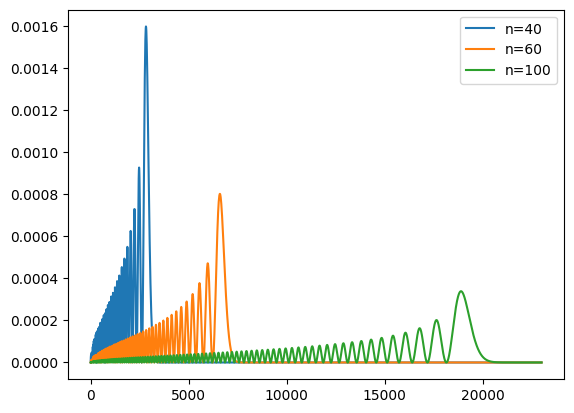

In [429]:
# now with Rydberg wavefunctions
nlist = [40, 60, 100]
l=2
j=3/2

rf = 23000

xpts = arange(0,rf,10)
for n in nlist:
    psi_r = get_psi_r(n,l,j,rmax=rf)
    plt.plot(xpts, [psi_r(x)**2 for x in xpts],label=f'n={n}')
plt.legend()
plt.show()

c:\users\gothr\.virtualenvs\science-base-vh-cqiz6\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
c:\users\gothr\.virtualenvs\science-base-vh-cqiz6\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


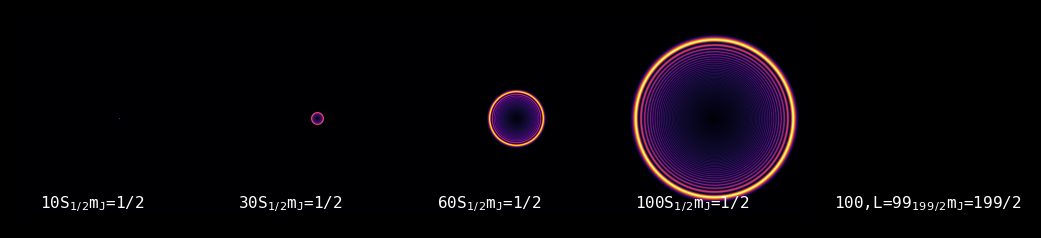

In [56]:
# again, but now with Rydberg states

# plot a wavefunction with both radial and angular parts.
# the angular part ends up being really slow. try with one term to diagnose.

nmax = 30
lmax = 2
jmax = 5/2
mjmax = jmax

# states = get_states(nmax,lmax,jmax,mjmax,nmin=nmax)

# Rydberg S states
states = [
    [10,0,1/2,1/2], # the ground state for comparison
    [30,0,1/2,1/2],
    [60,0,1/2,1/2],
    [100,0,1/2,1/2],
    [100,99,99.5,99.5]
]

l_dict = {0:"S",1:"P",2:"D",3:"F"}

rmax = 23000 # max radius

plt.set_cmap('inferno') # set the colormap

rows = 1
cols = len(states)

# the coordinate meshes
pts = 1000
xarr,midpt,rho,phi = get_meshgrid(rmax,pts,polar=True)
theta = full(rho.shape, pi/2) # use approx. to pi to avoid div by zero

plt.close()
plt.figure(facecolor='black',dpi=200)
gs = gridspec.GridSpec(rows,cols)
gs.update(wspace=0,hspace=0)

def configure_ax(ax):
    ax.set_aspect('equal')
    ax.set_axis_off()

# loop over states, plot each
for i,state in enumerate(states):

    # wavefunction params
    n,l,j,mj = state

    ylm_safe = lambda m,l,phi,theta: ylm(m,l,phi,theta) if abs(m) <= l else 0

    psi_r = get_psi_r(n,l,j,rmax=rmax,vector=True)
    psi_ylm = lambda theta,phi: float(clebsch_gordan(l,1/2,j,mj-1/2,1/2,mj))*ylm_safe(mj-1/2,l,phi,theta) + \
                                 float(clebsch_gordan(l,1/2,j,mj+1/2,-1/2,mj))*ylm_safe(mj+1/2,l,phi,theta)

    ylm_mesh = psi_ylm(phi,theta)
    r_mesh = psi_r(rho)

    psi_mesh = ylm_mesh*r_mesh
    prob_mesh = abs(psi_mesh)**2
#     print(amax(prob_mesh))
    prob_mesh /= amax(prob_mesh)
#     print(prob_mesh)

#     print("n={},l={},j={},mj={}".format(*state))
        
    ax = plt.subplot(gs[i])
    plt.axis('on')
    
    # settings that apply to each ax
    configure_ax(ax)
    
    if l in l_dict:
        lstr = l_dict[l]
    else:
        lstr = f",L={l}"
    
    jstr = "".join([r'$_{}$'.format(x) for x in halfint_to_fracstr(j)]) #  the J subscript
    ax.text(0.1*pts,0.95*pts,s=f'{n}{lstr}'+jstr+r'$\mathregular{m_J}$'+
            '='+halfint_to_fracstr(mj),
            color='white',size='xx-small',family='monospace')
    
    cax = ax.imshow(prob_mesh) #, extent=[-hw,hw,-hw,hw])
    # cax.set_norm(colors.Normalize(vmin=0, vmax=1))
#     cbar = fig.colorbar(cax)
# plt.subplots_adjust(hspace=0.0,wspace=0.0,right=0.7)
plt.show()

## misc testing

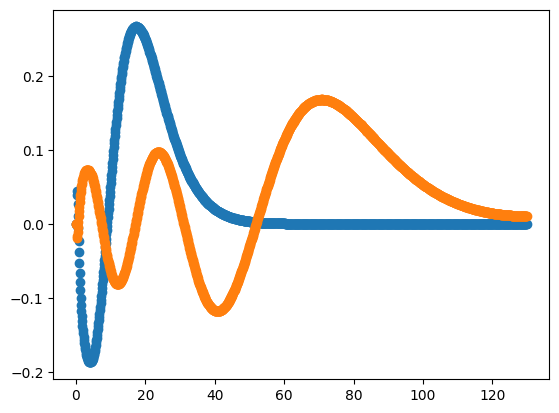

In [17]:
# radial part from interpolating function

# wavefunction params
n=5
l=2
j=3/2

rf = 130
psi_r1 = get_psi_r(n,l,j,rmax=rf)
psi_r2 = get_psi_r(n+3,l,j,rmax=rf)

xpts = arange(0,rf,.1)
plt.scatter(xpts, [psi_r1(x) for x in xpts])
plt.scatter(xpts, [psi_r2(x) for x in xpts])
plt.show()

1.0
0.0


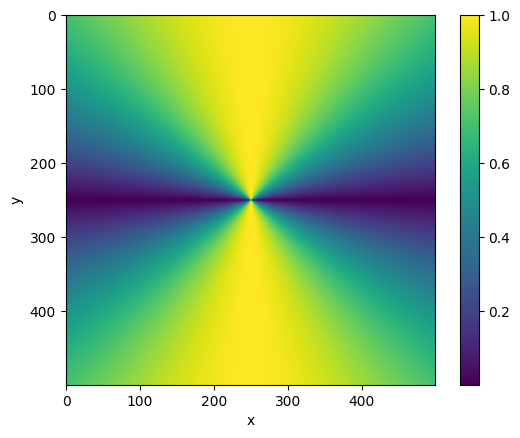

In [196]:
# spherical harmonic plots - fine structure

l = 1
j = 3/2
mj = 3/2

psi_ylm = lambda theta,phi: float(clebsch_gordan(l,1/2,j,mj-1/2,1/2,mj))*ylm_safe(mj-1/2,l,phi,theta) + \
                                 float(clebsch_gordan(l,1/2,j,mj+1/2,-1/2,mj))*ylm_safe(mj+1/2,l,phi,theta)

print(float(clebsch_gordan(l,1/2,j,mj-1/2,1/2,mj)))
print(float(clebsch_gordan(l,1/2,j,mj+1/2,-1/2,mj)))

xarr,midpt,rho,phi = get_meshgrid(rmax,pts,polar=True)
theta = full(rho.shape, 3.14) # use approx. to pi to avoid div by zero

ylm_mesh = psi_ylm(phi,theta)

ylmpts = abs(ylm_mesh)/amax(abs(ylm_mesh))

fig,ax = figax(xlabel='x', ylabel='y')
# fig.dpi=100
cax = ax.imshow(ylmpts)#, extent=[-hw,hw,-hw,hw])
# cax.set_norm(colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(cax)
plt.show()

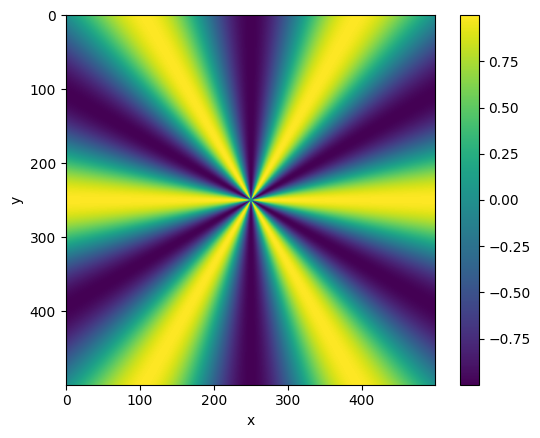

In [85]:
# spherical harmonic plots

hw=10 # units in a0k
pts = 500
xarr,midpt,rho,phi = get_meshgrid(hw,pts,polar=True)
theta = full(rho.shape, 0)

fig,ax = figax(xlabel='x', ylabel='y')
# fig.dpi=100
l = 6
m = 6
theta = pi/2
ylmpts = real(ylm(m,l,phi,theta))/amax(abs(ylm(m,l,phi,theta)))
cax = ax.imshow(ylmpts)#, extent=[-hw,hw,-hw,hw])
# cax.set_norm(colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(cax)
plt.show()